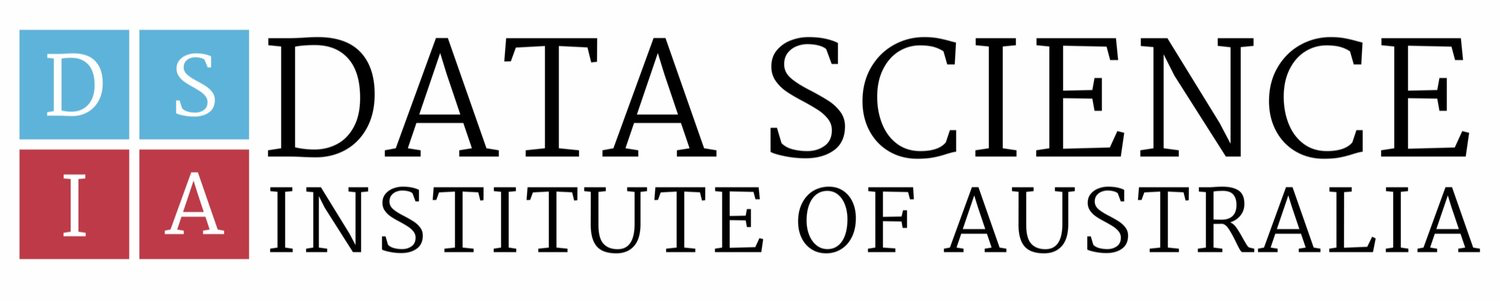

# Data Science and AI
## Lab 6.3.1: K-NN Classification

INSTRUCTIONS:

- Run the cells
- Observe and understand the results
- Answer the questions

## 1. Data
Features are computed from a digitized image of a fine needle aspirate (FNA) of a breast mass. They describe characteristics of the cell nuclei present in the image. n the 3-dimensional space is that described in: [K. P. Bennett and O. L. Mangasarian: "Robust Linear Programming Discrimination of Two Linearly Inseparable Sets", Optimization Methods and Software 1, 1992, 23-34].

This database is also available through the UW CS ftp server:
```shell
ftp ftp.cs.wisc.edu
cd math-prog/cpo-dataset/machine-learn/WDBC
```

Also can be found on [UCI Machine Learning Repository](https://archive.ics.uci.edu/ml/datasets/Breast+Cancer+Wisconsin+%28Diagnostic%29)

In [1]:
%matplotlib inline

In [2]:
# Import Libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('fivethirtyeight')

from ipywidgets import *
from IPython.display import display

from sklearn.svm import SVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import BernoulliNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import classification_report

from itertools import combinations
from scipy import stats

In [4]:
columns = ['id', 'diagnosis']
for k in ['mean', 'std_error', 'worst']:
    for c in ['radius', 'texture', 'perimeter', 'area', 'smoothness',
              'compactness', 'concavity', 'concave_points', 'symmetry', 'fractal_dimension']:
        columns.append('%s_%s' % (c, k))

In [5]:
breast_cancer = pd.read_csv('wdbc-data.csv', names=columns, index_col='id')

## 2. EDA 
Explore dataset. Clean data. Find correlation. 

In [6]:
def find_feature_correlations(df):
    
    """
    Find correlations between df features and convert to a format 
    with one feature1 vs. feature2 correlation value per row 
    
    _Params:_
    
    df: pandas DataFrame, features as columns. All datatypes must be numeric
    
    Returns a pandas DataFrame where a row contains one feature1 vs. feature2 correlation value
    """
    
    # initalise variable lists 
    var1 = []
    var2 = []
    pearsons = []
    
    # iterate over generator for tuples of feature combination pairs
    for comb in combinations(df.columns.tolist(), 2):
        
        v1 = comb[0] 
        var1.append(v1) # save feature 1 to list 

        v2 = comb[1]
        var2.append(v2) # save feature 2 to list
        
        p, _ = stats.pearsonr(df[v1], df[v2]) # get pearson correlation
        pearsons.append(p)
    
    # Build dataframe of feature1 vs. feature2 pearson correlation
    corr_df = pd.DataFrame({'Feature1': var1,
                            'Feature2': var2,
                            'P': pearsons})
    
    return corr_df

In [7]:
def find_feature_correlations_w(df):
    
    """
    Find correlations between df features and convert to a format 
    with one feature1 vs. feature2 correlation value per row 
    
    _Params:_
    
    df: pandas DataFrame, features as columns. All datatypes must be numeric
    
    Returns a pandas DataFrame where a row contains one feature1 vs. feature2 correlation value
    """
    
    corr = df.select_dtypes(np.number).corr() # df is the pandas dataframe
    c1 = corr.abs().unstack() # Create a data frame
    c1 = pd.DataFrame(c1)
    c1 = c1.reset_index()
    c1.columns = ['Feature 1', 'Feature 2', 'P']
    mask = pd.DataFrame(np.sort(c1[['Feature 1','Feature 2']], axis=1), index=c1.index).duplicated()
    corr_df = c1[~mask]
    corr_df
    
    return corr_df

In [8]:
find_feature_correlations(breast_cancer.select_dtypes(np.number))

,Feature1,Feature2,P
0,radius_mean,texture_mean,0.323782
1,radius_mean,perimeter_mean,0.997855
2,radius_mean,area_mean,0.987357
3,radius_mean,smoothness_mean,0.170581
4,radius_mean,compactness_mean,0.506124
...,...,...,...
430,concavity_worst,symmetry_worst,0.532520
431,concavity_worst,fractal_dimension_worst,0.686511
432,concave_points_worst,symmetry_worst,0.502528
433,concave_points_worst,fractal_dimension_worst,0.511114


In [9]:
breast_cancer.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'perimeter_mean',
       'area_mean', 'smoothness_mean', 'compactness_mean', 'concavity_mean',
       'concave_points_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_std_error', 'texture_std_error', 'perimeter_std_error',
       'area_std_error', 'smoothness_std_error', 'compactness_std_error',
       'concavity_std_error', 'concave_points_std_error', 'symmetry_std_error',
       'fractal_dimension_std_error', 'radius_worst', 'texture_worst',
       'perimeter_worst', 'area_worst', 'smoothness_worst',
       'compactness_worst', 'concavity_worst', 'concave_points_worst',
       'symmetry_worst', 'fractal_dimension_worst'],
      dtype='object')

In [10]:
# See the correlations in descending order

corr = breast_cancer.select_dtypes(np.number).corr() # df is the pandas dataframe
c1 = corr.abs().unstack()
c1 = pd.DataFrame(c1)
c1 = c1.reset_index()
c1.columns = ['Feature 1', 'Feature 2', 'P']
result_df = c1.drop_duplicates(subset=['Feature 1', 'Feature 2'], keep='first')
result_df

,Feature 1,Feature 2,P
0,radius_mean,radius_mean,1.000000
1,radius_mean,texture_mean,0.323782
2,radius_mean,perimeter_mean,0.997855
3,radius_mean,area_mean,0.987357
4,radius_mean,smoothness_mean,0.170581
...,...,...,...
895,fractal_dimension_worst,compactness_worst,0.810455
896,fractal_dimension_worst,concavity_worst,0.686511
897,fractal_dimension_worst,concave_points_worst,0.511114
898,fractal_dimension_worst,symmetry_worst,0.537848


In [11]:
mask = pd.DataFrame(np.sort(result_df[['Feature 1','Feature 2']], axis=1), index=result_df.index).duplicated()

df1 = result_df[~mask]
df1

,Feature 1,Feature 2,P
0,radius_mean,radius_mean,1.000000
1,radius_mean,texture_mean,0.323782
2,radius_mean,perimeter_mean,0.997855
3,radius_mean,area_mean,0.987357
4,radius_mean,smoothness_mean,0.170581
...,...,...,...
838,concave_points_worst,symmetry_worst,0.502528
839,concave_points_worst,fractal_dimension_worst,0.511114
868,symmetry_worst,symmetry_worst,1.000000
869,symmetry_worst,fractal_dimension_worst,0.537848


In [12]:
breast_cancer.shape

(569, 31)

In [13]:
breast_cancer.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 569 entries, 842302 to 92751
Data columns (total 31 columns):
diagnosis                      569 non-null object
radius_mean                    569 non-null float64
texture_mean                   569 non-null float64
perimeter_mean                 569 non-null float64
area_mean                      569 non-null float64
smoothness_mean                569 non-null float64
compactness_mean               569 non-null float64
concavity_mean                 569 non-null float64
concave_points_mean            569 non-null float64
symmetry_mean                  569 non-null float64
fractal_dimension_mean         569 non-null float64
radius_std_error               569 non-null float64
texture_std_error              569 non-null float64
perimeter_std_error            569 non-null float64
area_std_error                 569 non-null float64
smoothness_std_error           569 non-null float64
compactness_std_error          569 non-null float64
conca

In [14]:
# Head
breast_cancer.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave_points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave_points_worst,symmetry_worst,fractal_dimension_worst
id,,,,,,,,,,,,,,,,,,,,,
842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


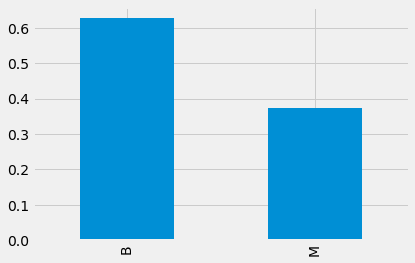

In [15]:
breast_cancer['diagnosis'].value_counts(normalize=True).plot(kind='bar')
plt.show()

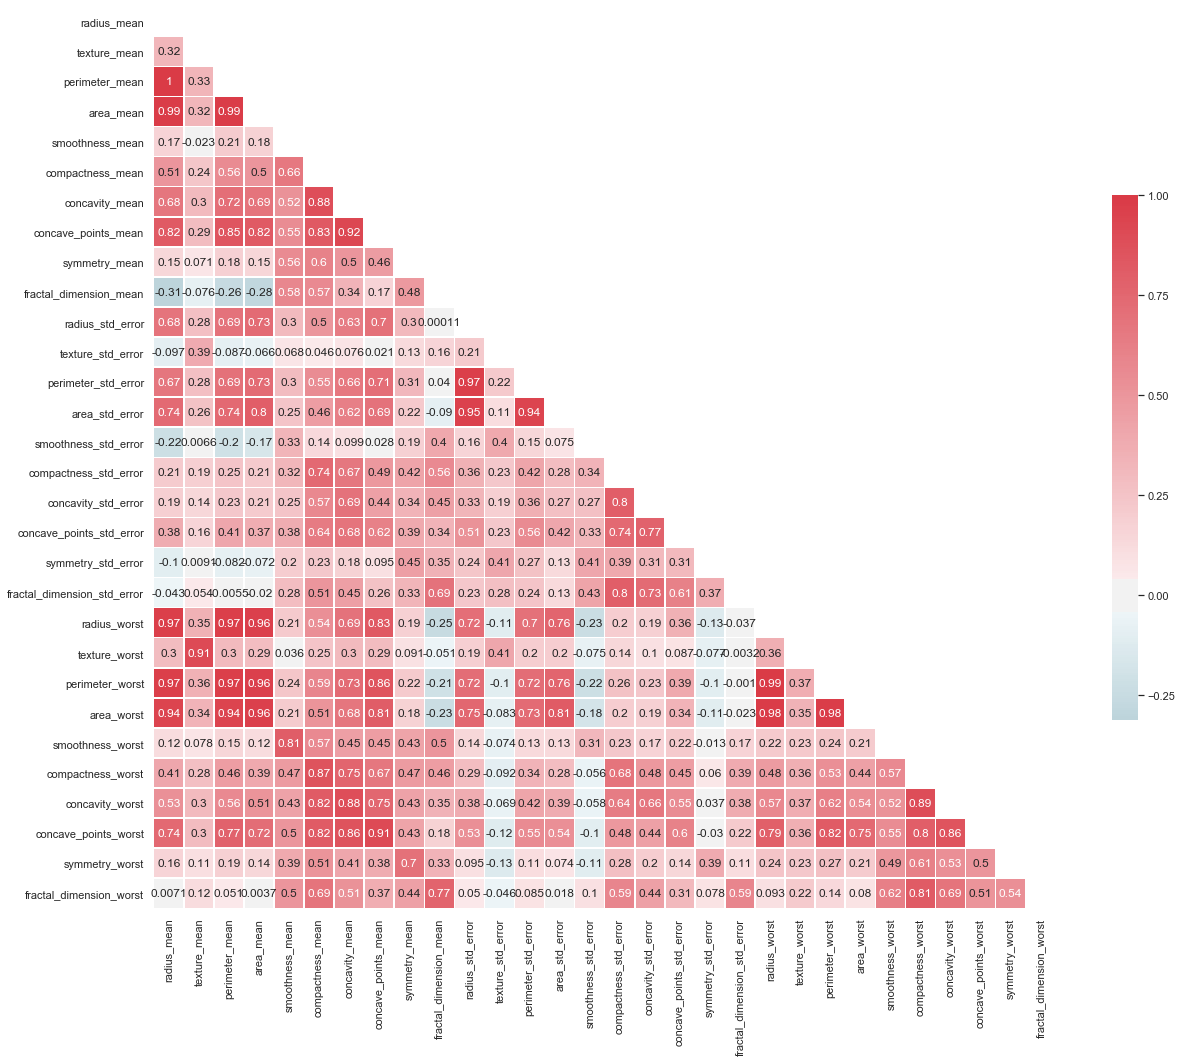

In [16]:
# Copied code from seaborn examples
# https://seaborn.pydata.org/examples/many_pairwise_correlations.html
sns.set(style="white")

# Generate a mask for the upper triangle
mask = np.zeros_like(breast_cancer.corr(), dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(18, 18))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(220, 10, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(breast_cancer.corr(), mask=mask, cmap=cmap, vmax=1, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5}, annot=True)

plt.show()

## 3. Set up the `diagnosis` variable as your target. How many classes are there?

In [17]:
target_column = 'diagnosis'
y = breast_cancer[target_column]

## 4. What is the baseline accuracy?

In [18]:
y.value_counts(normalize=True)

B    0.627417
M    0.372583
Name: diagnosis, dtype: float64

## 5. Choose features to be your predictor variables and set up your X

In [19]:
feature_columns = [c for c in breast_cancer.columns if c != 'diagnosis']
X = breast_cancer[feature_columns]

## 6. Fit a `KNeighborsClassifier` with 1 neighbour using the target and predictors

In [20]:
# make an instance of a KNeighborsClassifier object with 1 neighbor
knn = KNeighborsClassifier(n_neighbors=1)

# fit on the unstandardized data:
knn.fit(X, y)

KNeighborsClassifier(algorithm='auto', leaf_size=30, metric='minkowski',
                     metric_params=None, n_jobs=None, n_neighbors=1, p=2,
                     weights='uniform')

## 7. Evaluate the accuracy of your model
- Is it better than baseline?
- Is it legitimate?

In [21]:
# predict the response values for the observations in X ("test the model")
# store the predicted response values
y_pred_class = knn.predict(X)

print(accuracy_score(y, y_pred_class))

1.0


## 8. Create a 80-20 train-test-split of your target and predictors
Refit the KNN and assessthe accuracy.

In [22]:
# STEP 1: split X and y into training and testing sets (using random_state for reproducibility)
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42, test_size=0.2)

# STEP 2: train the model on the training set (using K=1)
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

# STEP 3: test the model on the testing set, and check the accuracy
y_pred_class = knn.predict(X_test)
print(accuracy_score(y_test, y_pred_class))

0.9298245614035088


## 9. Evaluate the test accuracy of a KNN where K == number of rows in the training data

In [23]:
knn = KNeighborsClassifier(n_neighbors=X_train.shape[0])
knn.fit(X_train, y_train)
y_pred_class = knn.predict(X_test)
print(accuracy_score(y_test, y_pred_class))

0.6228070175438597


## 10. Fit the KNN at values of K from 1 to the number of rows in the training data
- Store the test accuracy in a list.
- Plot the test accuracy vs. the number of neighbors.

In [24]:
# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, X_train.shape[0]+1):
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_train, y_train)
    test_acc.append(knn.score(X_test, y_test))

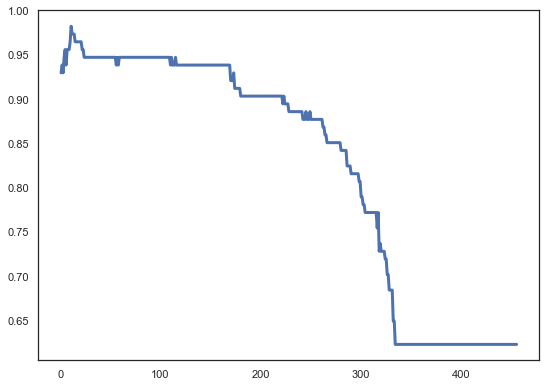

In [25]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(1, X_train.shape[0]+1)), test_acc, lw=3.)
plt.show()

## 11. Fit KNN across different values of K and plot the mean cross-validated accuracy with 5 folds

In [26]:
folds = 5
max_neighbors = np.floor(X.shape[0] - X.shape[0]/5.)

print(max_neighbors)

# plot test accuracy by number of neighbors:
test_acc = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc.append(np.mean(cross_val_score(knn, X, y, cv=5)))
    
print(max(test_acc))

455.0
0.9351904578684109


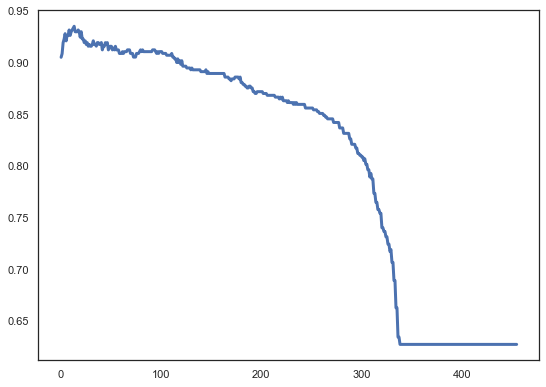

In [27]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(1, int(max_neighbors))), test_acc, lw=3.)
plt.show()

## 12. Standardize the predictor matrix and cross-validate across the different K
- Plot the standardized mean cross-validated accuracy against the unstandardized. Which is better?
- Why?

In [28]:
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [29]:
# plot test accuracy by number of neighbors:
test_acc_std = []
for i in range(1, int(max_neighbors)):
    knn = KNeighborsClassifier(n_neighbors=i)
    test_acc_std.append(np.mean(cross_val_score(knn, Xs, y, cv=5)))

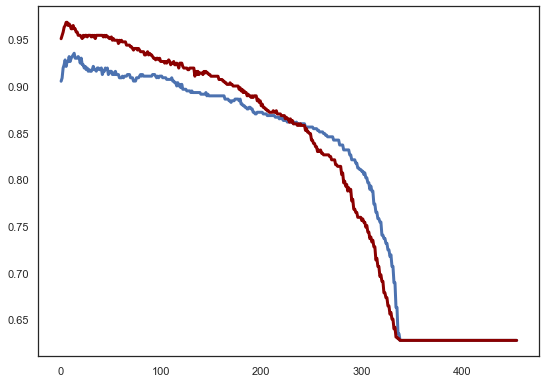

In [30]:
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(list(range(1, int(max_neighbors))), test_acc, lw=3.)
ax.plot(list(range(1, int(max_neighbors))), test_acc_std, lw=3., color='darkred')
plt.show()